# How to set the threshold using the Receiver operating characteristic (ROC) Curve


What is it?
* A graphic scheme for binary classification. 

What it represent?
* On the x-axis you have the False Positive Rate (FPR) 
* On the y-axis the True Positive Rate (TPR) 
* Each point of the curve is associated to a possible threshold 

How do I choose the threshold?
* You can choose the threshold you prefer as a trade-off between the TPR and  the FPR. However, **we will focus on FPR$<0.1$**

How can I generate the ROC?
* **To generate the ROC curve you need two arrays**: score and label

* These two arrays contains informations on the classifier positive and negative decision, respectively: H1 (similarity estimated between the same watermark) and H0 (similarity estimated between two different watermark).

* **In the score array**,  goes the similarity values between the watemark extracted from the watermarked image and those extracted from the attacked one.

* **In the label array**,  goes values equals either to 1 or 0. We put 1 if the watermarks extracted from the watermarked image and the attacked image, to estimate the corresponding similarity, are the same (H1 hypothesis). Otherwise, we put 0 (H0 hyphotesis).

AN EXAMPLE:


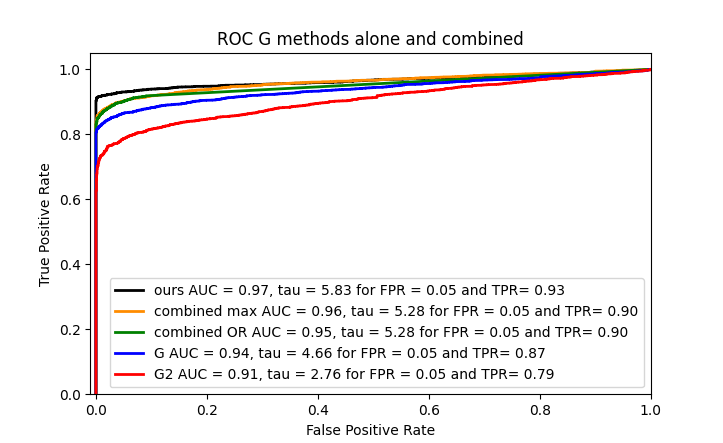




## A Toy-Example (Example 1)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

from sklearn.metrics import roc_curve, auc

score = np.asarray([1, 0.9, 0.8, 0.7, 0.75, 0.76, 0.88, 0.91, 0.7, 0.55, 0.6,
                      0.2, 0.5, 0.6, 0.7, 0.3, 0.44, 0.55, 0.61, 0.21, 0.5, 0.1])
label = np.asarray([1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0])
#compute ROC
fpr, tpr, tau = roc_curve(label, score, drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)

### How to plot the ROC

In [ ]:

# Plot the ROC curve for the toy example
import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (toy example)')
plt.legend(loc='lower right')
plt.show()


# How do I set the threshold?
A good threshold has a good trade off between TPR and FPR. Generally, the condition you care about is that your FPR never exceed a value of 0.05. For this challenge, all FPR $\leq 0.1$ are allowed. 

In [ ]:
idx_fpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0)) #locate the position corresponding to FPR=0.05
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_fpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_fpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_fpr[0][0]]) #"errors" due to approximations are possible when you do not have many data

### What FPR should I choose?

(Take Note)

# ROC applied to Watermarking (Example 2)

Let's apply what we learned to watermarking.

Function to embed/detect spread spectrum and apply a random attack.

In [ ]:

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from embedding import embedding as embed
from attacks import randomized_attack

# Embed the watermark and compute reference sign bits

def embed_and_get_reference(image_path: str, watermark_path: str):
    # Load the original image (must be 512x512 and grayscale)
    orig = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if orig is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")
    if orig.shape[0] != 512 or orig.shape[1] != 512:
        raise ValueError("Input image must be 512x512 pixels")
    # Embed the watermark using our embedding function
    watermarked = embed(image_path, watermark_path)
    # Compute DCTs
    dct_orig = cv2.dct(orig.astype(np.float32))
    dct_wm = cv2.dct(watermarked.astype(np.float32))
    # Determine embedding positions
    flat = dct_orig.ravel()
    sorted_idx = np.argsort(np.abs(flat))[::-1]
    embed_indices = sorted_idx[1:1025]
    # Compute reference sign bits (+1/-1)
    ref_sign = np.zeros(1024, dtype=np.int8)
    for i, idx in enumerate(embed_indices):
        r, c = divmod(int(idx), dct_orig.shape[1])
        ref_sign[i] = 1 if (dct_wm[r, c] - dct_orig[r, c]) >= 0 else -1
    return watermarked, dct_orig, embed_indices, ref_sign

# Apply a random attack and compute similarity scores for H1 and H0

def attack_and_score(watermarked: np.ndarray,
                     dct_orig: np.ndarray,
                     embed_indices: np.ndarray,
                     ref_sign: np.ndarray) -> tuple:
    attacked = randomized_attack(watermarked)
    dct_att = cv2.dct(attacked.astype(np.float32))
    att_sign = np.zeros(1024, dtype=np.int8)
    for i, idx in enumerate(embed_indices):
        r, c = divmod(int(idx), dct_orig.shape[1])
        att_sign[i] = 1 if (dct_att[r, c] - dct_orig[r, c]) >= 0 else -1
    sim_tp = float(np.sum(ref_sign == att_sign)) / len(ref_sign)
    fake_bits = np.random.randint(0, 2, 1024, dtype=np.uint8)
    fake_sign = 2 * fake_bits.astype(np.int8) - 1
    sim_fp = float(np.sum(fake_sign == att_sign)) / len(fake_sign)
    return sim_tp, sim_fp

# Compute ROC curve across all images in a directory

def compute_roc_from_dir(watermark_path: str,
                         images_dir: str,
                         n_samples: int = 500,
                         fpr_limit: float = 0.1,
                         plot_file: str = None) -> float:
    watermark = np.load(watermark_path).astype(np.uint8).flatten()
    if watermark.size != 1024:
        raise ValueError("Watermark must have length 1024")
    supported_exts = {'.bmp', '.png', '.jpg', '.jpeg', '.tif', '.tiff'}
    image_files = []
    for fname in sorted(os.listdir(images_dir)):
        if any(fname.lower().endswith(ext) for ext in supported_exts):
            image_files.append(os.path.join(images_dir, fname))
    if not image_files:
        raise FileNotFoundError(f"No supported images found in directory: {images_dir}")
    scores = []
    labels = []
    for img_path in image_files:
        orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if orig is None or orig.shape[0] != 512 or orig.shape[1] != 512:
            continue
        watermarked, dct_orig, embed_indices, ref_sign = embed_and_get_reference(img_path, watermark_path)
        sample = 0
        while sample < int(n_samples):
            sim_tp, sim_fp = attack_and_score(watermarked, dct_orig, embed_indices, ref_sign)
            scores.append(sim_tp)
            labels.append(1)
            scores.append(sim_fp)
            labels.append(0)
            sample += 1
    fpr, tpr, thresholds = roc_curve(labels, scores)
    valid_thresholds = thresholds[fpr <= fpr_limit]
    if len(valid_thresholds) == 0:
        tau = float(thresholds[np.argmin(fpr)])
    else:
        tau = float(np.max(valid_thresholds))
    tau = max(0.0, min(1.0, tau))
    if plot_file:
        plt.figure()
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (all images)')
        plt.grid(True)
        plt.savefig(plot_file)
        plt.close()
    else:
        plt.figure()
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (all images)')
        plt.grid(True)
        plt.show()
    return tau


In [ ]:

# Demonstrate embedding and reference preparation on a test image
# Update these paths to point to your image and watermark files
orig_path = 'test_img.bmp'
watermark_path = 'test_wm.npy'

# Embed the watermark and compute reference data
watermarked_img, dct_orig, embed_indices, ref_sign = embed_and_get_reference(orig_path, watermark_path)
print('Image shape:', watermarked_img.shape)


Build a mini dataset of 999 samples for the ROC.

**NOTE**: In this example we use Spread Spectrum.

In [ ]:

# Build a mini dataset of similarity scores and labels using randomized attacks
np.random.seed(124)

scores = []
labels = []

num_samples = 500
count = 0
while count < num_samples:
    sim_tp, sim_fp = attack_and_score(watermarked_img, dct_orig, embed_indices, ref_sign)
    scores.append(sim_tp)
    labels.append(1)
    scores.append(sim_fp)
    labels.append(0)
    count += 1

scores = np.asarray(scores)
labels = np.asarray(labels)


## Compute the ROC

In [ ]:

# Compute ROC for the watermarking example
fpr, tpr, tau = roc_curve(labels, scores, drop_intermediate=False)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (watermarking example)')
plt.legend(loc='lower right')
plt.show()
